In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc, precision_score
import scipy.stats

import seaborn as sns
from MutBkgd import MutationBackground

%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999; 

<IPython.core.display.Javascript object>

In [17]:
prefix = 'HS.'

s_het = np.load('../data/gene/s_het.npy').item()
prec = np.load('../data/gene/prec.npy').item()
pli = np.load('../data/gene/pli.npy').item()
lofz = np.load('../data/gene/lofz.npy').item()

HIS_gene = set(gene for gene, pli_score in pli.iteritems() if pli_score < 0.5)
HS_gene = set(gene for gene, pli_score in pli.iteritems() if pli_score >= 0.5)
prec_5 = set(gene for gene, pli_score in prec.iteritems() if pli_score >0.5)
lofz3 = set(gene for gene, score in lofz.iteritems() if score >= 3)

geneset = HIS_gene #& lofz3

# compare confusion matrix

In [4]:
def plot_multi_confusion_matrix(df, y_true, dataset, save=False,
                                class_names = ['damage_negative', 'damage_positive']):
    '''take a dataframe with predictors and y_true value, output multiple confusion matrix plot
    '''
    
    # 'M-CAP_rankscore', 0.4815 is 0.025 cutoff 0.642 is 0.05 cutoff
    col_dict={'cadd15':('CADD_phred', 15), 'cadd20':('CADD_phred', 20),
              'cadd25':('CADD_phred', 25), 'cadd30':('CADD_phred', 30),
              'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              'eigen_pc_pred10':('Eigen-PC-phred', 10), 
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122), 
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642), 
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHMM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', 0.0),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_best_0.56':('cnn_prob', 0.56)}
    
    y_preds, y_algos = [], []
    for key, (col, threshold) in col_dict.items():
        y_algos.append(key)
        y_preds.append(convert2binary(df, col, threshold))

    infos = []
    for y_pred, y_algo in zip(y_preds, y_algos):
        # Compute confusion matrix
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        cnf_matrix = confusion_matrix(y_true, y_pred)
        fdr = 1 - precision_score(y_true, y_pred)
        np.set_printoptions(precision=2)

        title = '../figure/' + dataset + y_algo + '.png'
        # Plot non-normalized confusion matrix
        figure_title = 'Confusion matrix, without normalization\n{}\n{}\n accuracy: {:.2f}\n f1: {:.2f}\n'.format(
            dataset, y_algo, accuracy, f1)
        fig = plt.figure(figsize = (5,5))
        plot_confusion_matrix(cnf_matrix, classes=class_names,
                              title=figure_title)
        
        if save:
            infos.append([y_algo, accuracy, f1, fdr])
            fig.savefig(title)
            plt.close()
        else:
            plt.show()
    labels = ['Col', 'accuracy', 'f1', 'FDR']            
    df = pd.DataFrame(infos,columns=labels)
    display(df)

def convert2binary(df, col, threshold):
    '''take a dataframe, col to compare, threshold, return the binary vector
        convert to more elegent lambda function way 
        http://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
    '''
    values = np.array(df[col].values)
    index = values >= threshold
    values[index] = 1
    values[~index] = 0
    return values

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=45)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
class_names = ['damage_negative', 'damage_positive'] # 0 for 'damage_negative', 1 for 'damage_positive'

validation = '../data/output/output_data_mode5.csv'
fname = validation
df = pd.read_csv(fname)
df = df[df.training==0]
y_true = df.pop('target')
dataset = 'validation(20% HGMD,DiscovEHR)'
plot_multi_confusion_matrix(df, y_true, dataset, save=True)

/Users/hongjian/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (58,62,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Col,accuracy,f1,FDR
0,all_missense,0.501803,0.668267,0.498197
1,PP2-HVAR,0.742640,0.708286,0.178731
2,cnn_0.7,0.924594,0.927324,0.102056
3,eigen_pred10,0.630583,0.442665,0.088930
4,FATHMM,0.782696,0.759156,0.144786
5,cnn_0.05,0.777388,0.818011,0.306496
6,cadd20,0.823353,0.838845,0.226453
7,cnn_0.6,0.917484,0.921851,0.121634
8,cnn_0.5,0.909974,0.916005,0.138791
9,cnn_0.4,0.898858,0.907101,0.158676


In [10]:
fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.cnn.csv']

for fname in fnames:
    df = pd.read_csv(fname)
    y_true = df.pop('target')
    dataset = fname.split('_')[-1].split('.')[0]
    print dataset
    plot_multi_confusion_matrix(df, y_true, dataset, save=True)


test1


,Col,accuracy,f1,FDR
0,all_missense,0.395522,0.566845,0.604478
1,PP2-HVAR,0.686567,0.625000,0.406780
2,cnn_0.7,0.865672,0.804348,0.051282
3,eigen_pred10,0.634328,0.289855,0.375000
4,FATHMM,0.746269,0.595238,0.193548
5,cnn_0.05,0.798507,0.776860,0.308824
6,cadd20,0.723881,0.725926,0.402439
7,cnn_0.6,0.865672,0.804348,0.051282
8,cnn_0.5,0.880597,0.829787,0.048780
9,cnn_0.4,0.902985,0.865979,0.045455


/Users/hongjian/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (58) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


test2


,Col,accuracy,f1,FDR
0,all_missense,0.384819,0.555768,0.615181
1,PP2-HVAR,0.710990,0.642795,0.387090
2,cnn_0.7,0.896530,0.865944,0.136519
3,eigen_pred10,0.688094,0.382497,0.196925
4,FATHMM,0.843783,0.803761,0.222056
5,cnn_0.05,0.746390,0.748647,0.394893
6,cadd20,0.637196,0.650314,0.483135
7,cnn_0.6,0.892920,0.864829,0.159101
8,cnn_0.5,0.885435,0.859153,0.184713
9,cnn_0.4,0.877686,0.853373,0.207917


addtest1


,Col,accuracy,f1,FDR
0,all_missense,0.540167,0.701440,0.459833
1,PP2-HVAR,0.730072,0.742629,0.234340
2,cnn_0.7,0.911294,0.917027,0.073225
3,eigen_pred10,0.603261,0.447403,0.096627
4,FATHMM,0.832709,0.841875,0.139945
5,cnn_0.05,0.802036,0.843699,0.264448
6,cadd20,0.714705,0.775124,0.325073
7,cnn_0.6,0.911482,0.918643,0.087799
8,cnn_0.5,0.907921,0.916751,0.104095
9,cnn_0.4,0.903611,0.914244,0.119944


addtest2


,Col,accuracy,f1,FDR
0,all_missense,0.557154,0.715606,0.442846
1,PP2-HVAR,0.725835,0.744739,0.226264
2,cnn_0.7,0.909585,0.917960,0.071749
3,eigen_pred10,0.591909,0.448845,0.093333
4,FATHMM,0.831795,0.845415,0.133725
5,cnn_0.05,0.804847,0.849547,0.255389
6,cadd20,0.720133,0.783672,0.311769
7,cnn_0.6,0.910060,0.919809,0.086109
8,cnn_0.5,0.906734,0.918156,0.101748
9,cnn_0.4,0.902661,0.915875,0.116768


train


,Col,accuracy,f1,FDR
0,all_missense,0.513932,0.678937,0.486068
1,PP2-HVAR,0.754957,0.754326,0.221935
2,cnn_0.7,0.921678,0.923127,0.068624
3,eigen_pred10,0.626704,0.455358,0.089896
4,FATHMM,0.824386,0.822219,0.143036
5,cnn_0.05,0.813846,0.845726,0.263408
6,cadd20,0.738225,0.783693,0.318921
7,cnn_0.6,0.925301,0.927973,0.080206
8,cnn_0.5,0.922337,0.926326,0.096208
9,cnn_0.4,0.918714,0.923968,0.110346


# ROC

In [11]:
def plot_roc(df, y_true, label):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    algos = ['cnn_prob', 'MetaSVM_rankscore', 'MetaLR_rankscore', 'M-CAP_rankscore', 
             'DANN_rankscore','CADD_phred', 'Eigen-phred','Polyphen2_HVAR_rankscore', 
             'MutationTaster_converted_rankscore', 'FATHMM_converted_rankscore', 
             'fathmm-MKL_coding_rankscore']
    for algo in algos:
        index = (df[algo]!= -1) & (df[algo]!= 0)
        y_score = df.ix[index][algo].values
        y_true_nomissing = y_true[index]

        fpr[algo], tpr[algo], _ = roc_curve(y_true_nomissing, y_score)
        roc_auc[algo] = auc(fpr[algo], tpr[algo])
    # jump comes from missing value

    plt.figure(figsize = (10,10))
    lw = 2
    for algo in algos:
        plt.plot(fpr[algo], tpr[algo], lw=lw, 
                 label='{} ROC curve (area = {:.2f})'.format(algo, roc_auc[algo]))

        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    total = len(y_true)
    pos = sum(y_true)
    neg = total - pos
    
    plt.title('Receiver operating characteristic of {}: {} positive, {} negative'.format(label, pos, neg))
    plt.legend(loc="lower right", fontsize = 'medium')
    plt.show()
    
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters based on distance
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'dist' : pd.Series(abs(tpr-fpr), index=i), 'threshold' : pd.Series(threshold, index=i),
                        'fpr':pd.Series(fpr, index=i), 'tpr':pd.Series(tpr, index=i)})
    roc_t = roc.ix[roc.dist.argsort()]
    return roc_t.tail(3)

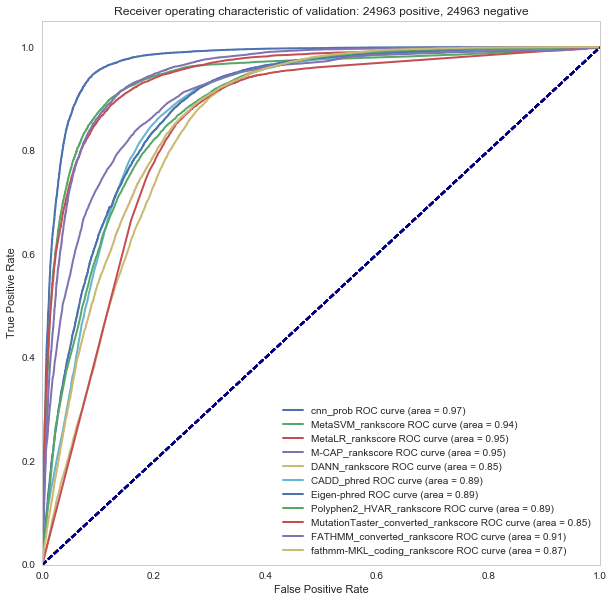

,dist,fpr,threshold,tpr
8754,0.856347,0.091415,0.759824,0.947763
8748,0.856387,0.091095,0.761278,0.947482
8772,0.856387,0.092216,0.756895,0.948604


In [21]:
class_names = ['damage_negative', 'damage_positive']
fname = validation
df = pd.read_csv(fname)
y_true = df.pop('target')
plot_roc(df, y_true, label = 'validation')
Find_Optimal_Cutoff(y_true, df['cnn_prob'])

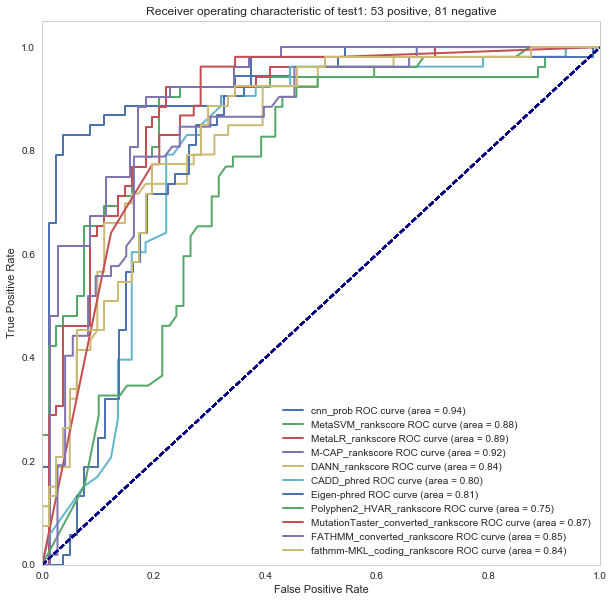

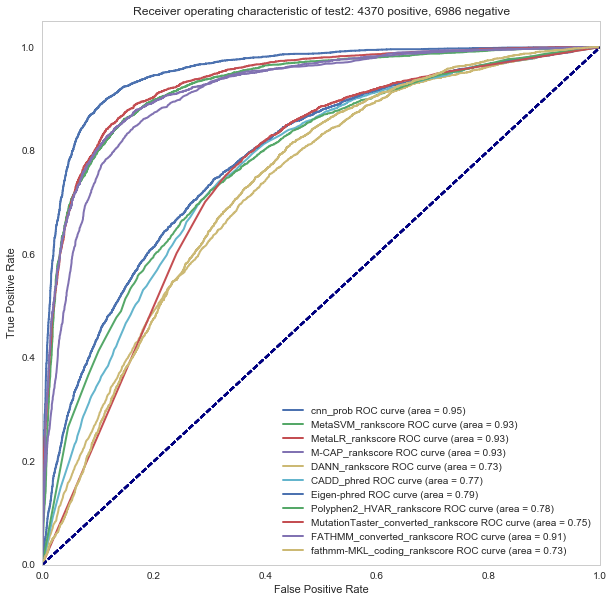

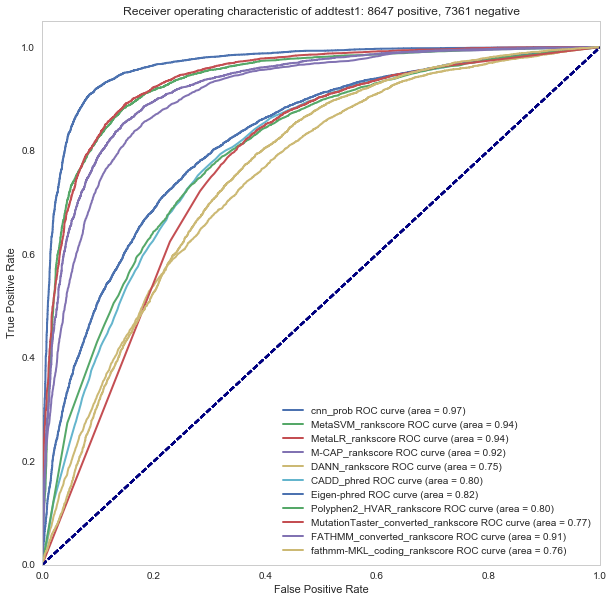

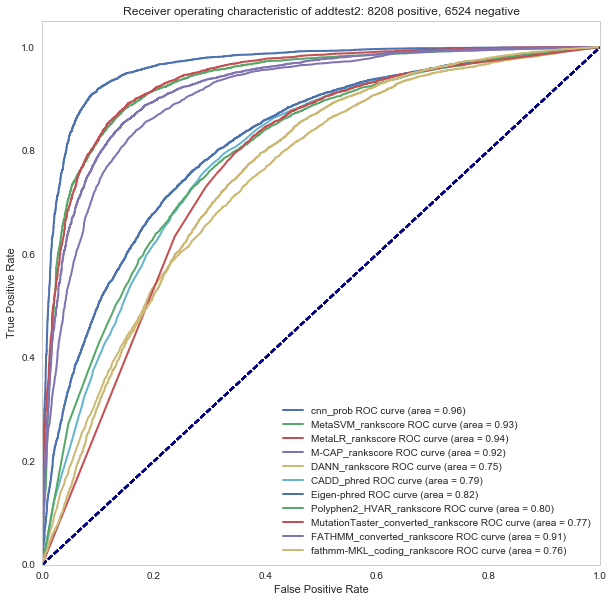

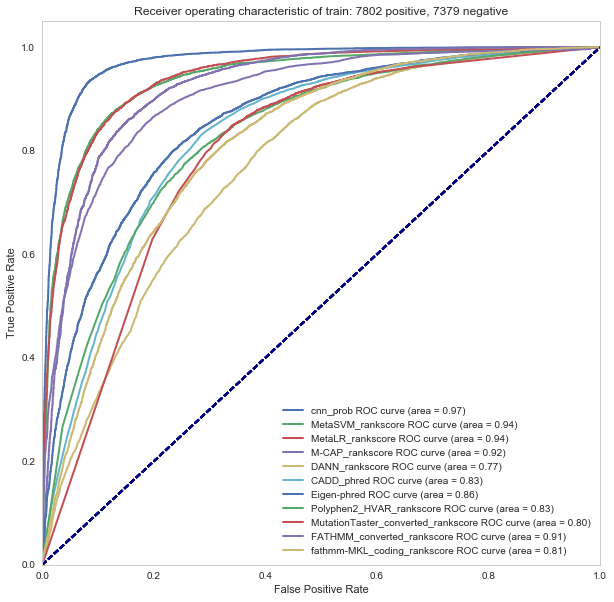

In [13]:
# metaSVM test
fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.cnn.csv']
labels = []
for fname in fnames:
    labels.append(fname.split('_')[-1].split('.')[0])
    
for fname, lable in zip(fnames, labels):
    df = pd.read_csv(fname)
    y_true = df.pop('category')
    index = y_true == 'TP'
    y_true[index] = 1
    y_true[~index] = 0
    y_true = y_true.astype(int)
    plot_roc(df, y_true, lable)

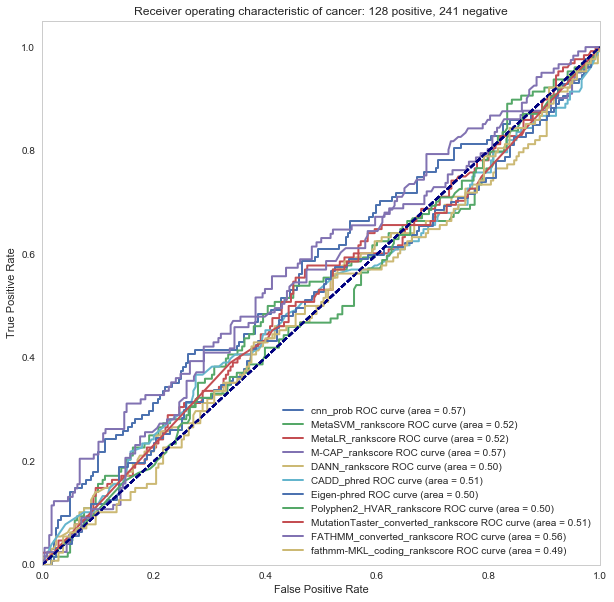

In [14]:
class_names = ['cancer_passengers', 'cancer_hotspot']
fname = '../data/cancer_hotspots/cancer.'+prefix+'reformat.cnn.csv'
df = pd.read_csv(fname)
y_true = df.pop('target')
plot_roc(df, y_true, label = 'cancer')

# enrichment

In [15]:
fname = '../data/gene/gene_mutation_rate0520.txt'
mutation_bkgrd = MutationBackground(fname)

def display_enrichment(case_info, control_info, case_disease, geneset, sort_key='Col'):
    
    print case_disease
    df_case, case_disease, disease_size = case_info 
    df_control, control_disease, disease_size = control_info 
    case_size = 0.0
    for disease in case_disease:
        if disease in disease_size:
            case_size += disease_size[disease]
    control_size = 0.0
    for disease in control_disease:
        control_size += disease_size[disease]
    print 'case size:{} control size:{}'.format(case_size, control_size)
    
    # add PDmis columns
    df_case['PDmis'] = np.where((df_case['CADD_phred'] >= 15) & (df_case['Polyphen2_HDIV_rankscore'] >= 0.52875) , 1, 0)
    df_control['PDmis'] = np.where((df_control['CADD_phred'] >= 15) & (df_control['Polyphen2_HDIV_rankscore'] >= 0.52875) , 1, 0)
    # 'M-CAP_rankscore', 0.4815 is 0.025 cutoff 0.642 is 0.05 cutoff
    col_dict={'cadd15':('CADD_phred', 15), 'cadd20':('CADD_phred', 20),
              'cadd25':('CADD_phred', 25), 'cadd30':('CADD_phred', 30),
              'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              'eigen_pc_pred10':('Eigen-PC-phred', 10), 
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122), 
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642), 
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHMM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', 0.0),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_best_0.56':('cnn_prob', 0.56)}

    
    infos = [] 
    for col_name, (col, threshold) in col_dict.items():
        case_count = np.sum(convert2binary(df_case, col, threshold))
        control_count = np.sum(convert2binary(df_control, col, threshold))
        total_counts = case_count + control_count
        #control_count = max(control_count, 1)
        enrich = float(case_count) / case_size / (float(control_count) / control_size)
        pvalue = scipy.stats.binom_test(case_count, total_counts,
                                            case_size / (case_size + control_size))
        risk_gene = case_count * (enrich - 1) / enrich
        #enrich = max(enrich, 1)
        tpr = (enrich - 1) / enrich
        
        exp = mutation_bkgrd.expectation(geneset, col_name) * case_size
        exp_enr = case_count / exp
        exp_risk_gene = case_count * (exp_enr - 1) / exp_enr
        exp_tpr = (exp_enr - 1) / exp_enr
        
        
        infos.append([col_name, case_count, control_count, 
                      enrich, pvalue, risk_gene, tpr,
                      exp, exp_enr, exp_risk_gene, exp_tpr])
        
    
    labels = ['Col', 'Case', 'Control', 'enrich', 'pvalue', '# risk gene', 'true positive rate',
              'exp', 'exp_enr', 'exp_risk_gene', 'exp_tpr']            
    df = pd.DataFrame(infos,columns=labels)
    df = df.sort_values(by=sort_key, ascending=True)
    display(df)
    plot_rate_vs_riskvariants(df, title=','.join(case_disease))
    return df

def plot_rate_vs_riskvariants(df, title):
    x = list(df['true positive rate'])
    y = list(df['# risk gene'])
    
#     x = list(df['exp_tpr'])
#     y = list(df['exp_risk_gene'])
    methods = list(df['Col'])
    fig, ax = plt.subplots(figsize = (15,10))
    ax.scatter(x, y, s=100)
    for i, txt in enumerate(methods):
        if 'cnn' in txt:
            color = 'red'
        elif 'all_missense' in txt:
            color = 'blue'
        else:
            color = 'black'
        ax.annotate(txt, (x[i],y[i]), fontsize=15, color=color)
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xlabel('true positive rate', fontsize=15)
    ax.set_ylabel('# risk gene', fontsize=15)
    
    case_variants, control_variants = df.ix[df['Col']=='all_missense'][['Case', 'Control']].values[0]
    
    ax.set_title('{}: {} variants in cases, {} variants in controls'.format(title, 
                                            case_variants, control_variants), fontsize=15)  

something wrong: EFNA1
something wrong: FAM231A
something wrong: XK
something wrong: EPS8L1
something wrong: ZNF83
something wrong: GALNTL6
something wrong: PRAMEF19
something wrong: GJC3


['ASD']
case size:3953.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,272.0,103.0,1.276631,0.036190,58.939299,0.216689,254.872626,1.067200,17.127374,0.062968
21,M_CAP>0.025,772.0,326.0,1.144810,0.042482,97.652538,0.126493,1505.080126,0.512930,-733.080126,-0.949586
17,M_CAP>0.05,527.0,203.0,1.255014,0.005686,107.084249,0.203196,556.214076,0.947477,-29.214076,-0.055435
20,MetaLR>0,323.0,122.0,1.279902,0.019954,70.636839,0.218690,306.392517,1.054203,16.607483,0.051416
18,MetaSVM>0,303.0,123.0,1.190889,0.109013,48.568289,0.160291,286.516051,1.057532,16.483949,0.054402
1,PP2-HVAR,556.0,245.0,1.097091,0.242573,49.205128,0.088498,531.229860,1.046628,24.770140,0.044551
0,all_missense,1679.0,730.0,1.111890,0.016798,168.958137,0.100630,1561.112814,1.075515,117.887186,0.070213
19,cadd15,1230.0,532.0,1.117705,0.032753,129.531136,0.105310,1107.681283,1.110428,122.318717,0.099446
6,cadd20,1089.0,462.0,1.139514,0.018436,133.329670,0.122433,969.253285,1.123545,119.746715,0.109960
11,cadd25,659.0,274.0,1.162703,0.036118,92.217164,0.139935,547.164842,1.204390,111.835158,0.169704


['DDD_new']
case size:4293.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,333.0,103.0,1.439152,0.001060,101.613815,0.305147,276.794380,1.203059,56.205620,0.168786
21,M_CAP>0.025,935.0,326.0,1.276715,0.000120,202.651491,0.216740,1634.533008,0.572029,-699.533008,-0.748164
17,M_CAP>0.05,640.0,203.0,1.403407,0.000017,183.967033,0.287448,604.054396,1.059507,35.945604,0.056165
20,MetaLR>0,409.0,122.0,1.492325,0.000075,134.930926,0.329904,332.745529,1.229168,76.254471,0.186441
18,MetaSVM>0,389.0,123.0,1.407811,0.000791,112.684458,0.289677,311.159476,1.250163,77.840524,0.200104
1,PP2-HVAR,681.0,245.0,1.237317,0.003929,130.615385,0.191799,576.921272,1.180404,104.078728,0.152832
0,all_missense,1843.0,730.0,1.123834,0.007598,203.078493,0.110189,1695.385103,1.087069,147.614897,0.080095
19,cadd15,1407.0,532.0,1.177287,0.001268,211.879121,0.150589,1202.953642,1.169621,204.046358,0.145022
6,cadd20,1233.0,462.0,1.188012,0.001453,195.131868,0.158258,1052.619365,1.171364,180.380635,0.146294
11,cadd25,748.0,274.0,1.215209,0.005456,132.467818,0.177096,594.226832,1.258779,153.773168,0.205579


['CHD_yale']
case size:2645.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,207.0,103.0,1.452005,0.001850,64.438514,0.311297,170.538350,1.213803,36.461650,0.176143
21,M_CAP>0.025,575.0,326.0,1.274340,0.000442,123.785976,0.215280,1007.067274,0.570965,-432.067274,-0.751421
17,M_CAP>0.05,381.0,203.0,1.356013,0.000421,100.029304,0.262544,372.169550,1.023727,8.830450,0.023177
20,MetaLR>0,235.0,122.0,1.391692,0.003129,66.140764,0.281450,205.010930,1.146280,29.989070,0.127613
18,MetaSVM>0,231.0,123.0,1.356881,0.005988,60.756672,0.263016,191.711347,1.204937,39.288653,0.170081
1,PP2-HVAR,412.0,245.0,1.214972,0.015867,72.897436,0.176936,355.452310,1.159087,56.547690,0.137252
0,all_missense,1177.0,730.0,1.164900,0.001157,166.612768,0.141557,1044.559422,1.126791,132.440578,0.112524
19,cadd15,851.0,532.0,1.155721,0.008891,114.663004,0.134739,741.162913,1.148196,109.837087,0.129068
6,cadd20,765.0,462.0,1.196340,0.002375,125.549451,0.164117,648.539069,1.179574,116.460931,0.152237
11,cadd25,459.0,274.0,1.210311,0.012157,79.758765,0.173766,366.114598,1.253706,92.885402,0.202365


['SSC_yale']
case size:1789.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,115.0,103.0,1.192644,0.198447,18.575615,0.161527,115.347111,0.996991,-0.347111,-0.003018
21,M_CAP>0.025,344.0,326.0,1.127175,0.122224,38.812140,0.112826,681.150606,0.505028,-337.150606,-0.980089
17,M_CAP>0.05,224.0,203.0,1.178697,0.090335,33.959707,0.151606,251.724508,0.889862,-27.724508,-0.123770
20,MetaLR>0,131.0,122.0,1.146996,0.285270,16.788592,0.128157,138.663348,0.944734,-7.663348,-0.058499
18,MetaSVM>0,131.0,123.0,1.137671,0.315494,15.852433,0.121011,129.667902,1.010273,1.332098,0.010169
1,PP2-HVAR,254.0,245.0,1.107434,0.262928,24.641026,0.097012,240.417460,1.056496,13.582540,0.053475
0,all_missense,757.0,730.0,1.107703,0.048652,73.603872,0.097231,706.509189,1.071465,50.490811,0.066699
19,cadd15,542.0,532.0,1.088273,0.169517,43.963370,0.081113,501.300737,1.081187,40.699263,0.075091
6,cadd20,468.0,462.0,1.082067,0.237560,35.494505,0.075843,438.652701,1.066903,29.347299,0.062708
11,cadd25,275.0,274.0,1.072093,0.417516,18.492412,0.067245,247.629118,1.110532,27.370882,0.099530


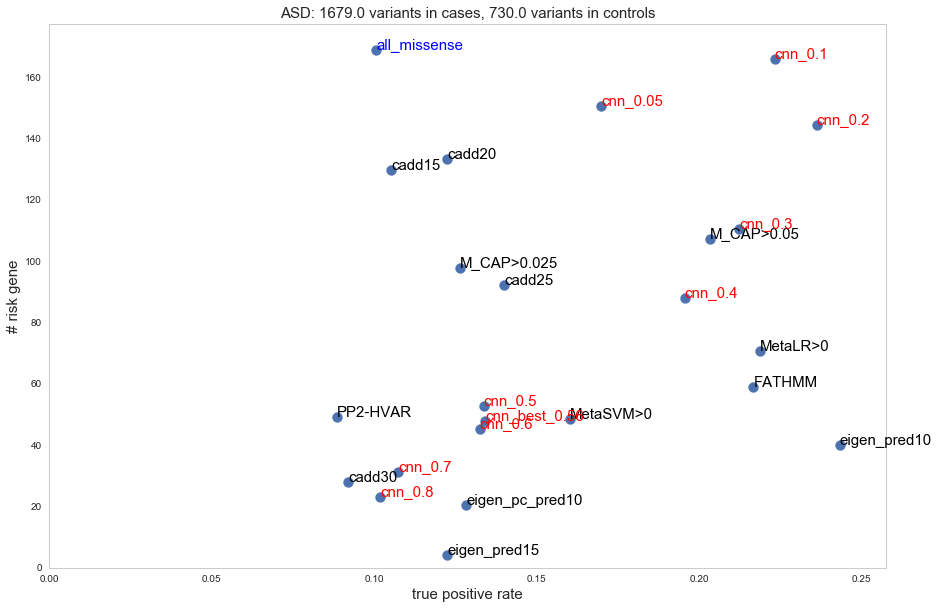

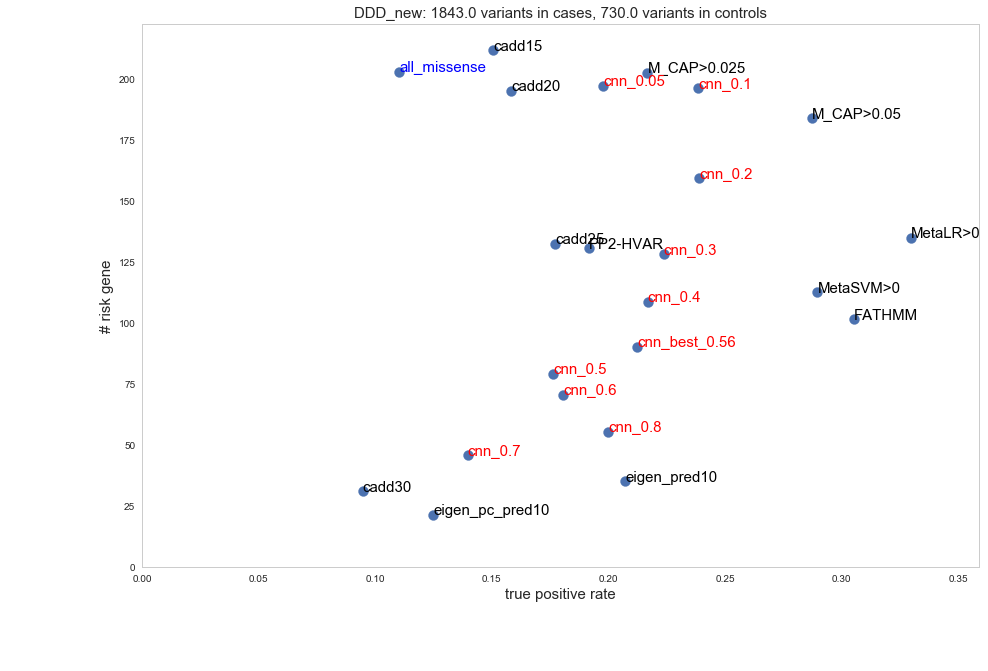

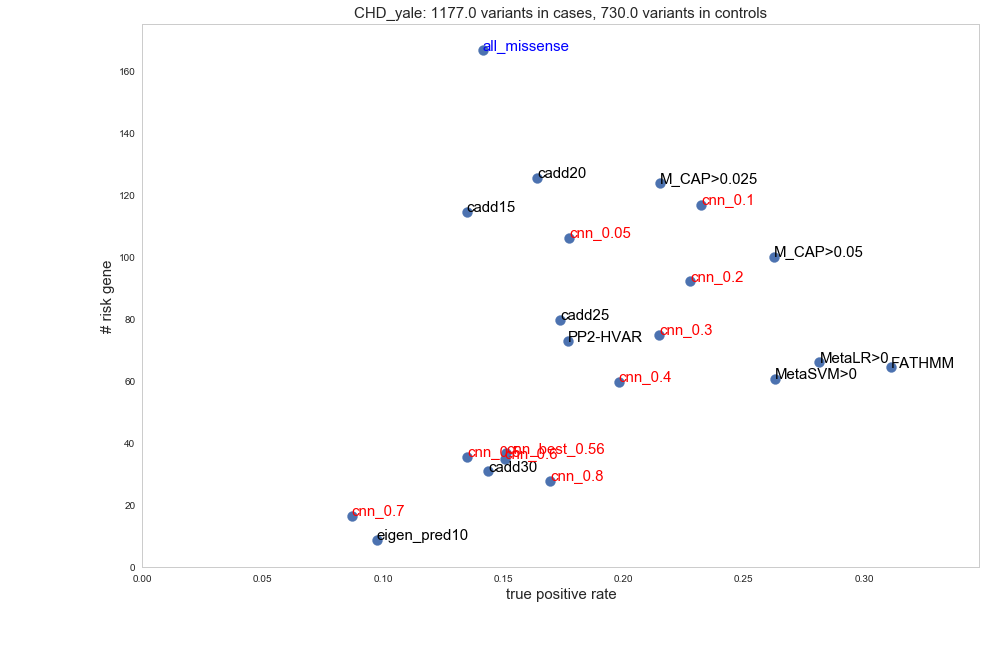

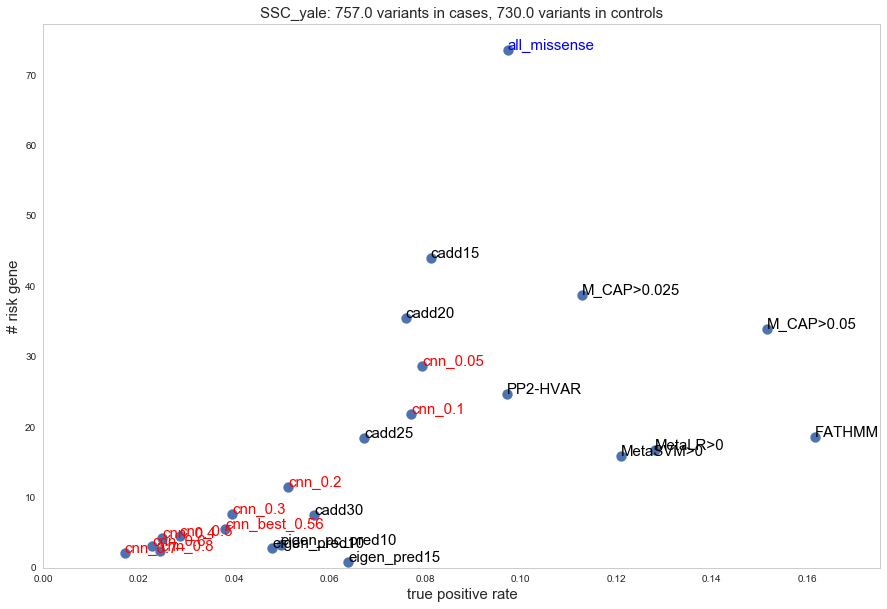

In [19]:


disease_size = {'CHD':2779, 'CDH':307,'CDH_MGH':80,
                'ASD':3953, 'EE':264, 'ID':192,
                'DDD_new':4293, 'DDD':1133, 'SSC':1911,
                'CHD_yale':2645, 'SSC_yale':1789 } 




fname = '../data/case_control/ssc_yale.anno.rare.'+prefix+'reformat.cnn.csv'
control_disease = ['SSC_yale']

fname = '../data/case_control/control_1911.anno.rare.'+prefix+'reformat.cnn.csv'
control_disease = ['SSC']

df_control = pd.read_csv(fname)
index = df_control['disease'].isin(control_disease) & df_control['genename'].isin(geneset) 
#index = index & (df_control['prec'] >=0.8)

df_control = df_control[index]
control_info = (df_control, control_disease, disease_size)



# data is a little more than ANNOVAR annotatoin, do a comparison later
case_diseases = [['CHD'], ['CDH'], ['ASD'],['EE'], ['ID'], ['DDD'], 
                 ['CHD', 'CDH', 'ASD','EE', 'ID', 'DDD']]

case_diseases = [['ASD']]

for case_disease in case_diseases:

    fname = '../data/case_control/case.anno.rare.'+prefix+'reformat.cnn.csv'
    df_case = pd.read_csv(fname)
    index = df_case['disease'].isin(case_disease) & df_case['genename'].isin(geneset) 
    
    df_case = df_case[index]
    case_info = (df_case, case_disease, disease_size)
    df = display_enrichment(case_info, control_info, case_disease, geneset)

fname = '../data/case_control/DDD_new_0.2.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['DDD_new']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)

    
fname = '../data/case_control/chd_yale.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['CHD_yale']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)


fname = '../data/case_control/ssc_yale.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['SSC_yale']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)